In [1]:
import os
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
folder = r"D:\Downloads\Project33"
csv_files = [
    "aisles.csv",
    "departments.csv",
    "products.csv",
    "order_products_train.csv",
    "order_products_prior.csv",
    "orders.csv"
]

for fname in csv_files:
    csv_path = os.path.join(folder, fname)
    parquet_path = csv_path.replace(".csv", ".parquet")

    if os.path.exists(csv_path):
        try:
            print(f"Loading {fname}...")
            df = pd.read_csv(csv_path)
            print(f"Writing {fname[:-4]}.parquet...")
            df.to_parquet(parquet_path, engine="pyarrow", index=False)
            print(f"Converted {fname} to Parquet.")
        except Exception as e:
            print(f"Failed to convert {fname}: {e}")
    else:
        print(f"File not found: {fname}")

print("\n All conversions done!")

Loading aisles.csv...
Writing aisles.parquet...
Converted aisles.csv to Parquet.
Loading departments.csv...
Writing departments.parquet...
Converted departments.csv to Parquet.
Loading products.csv...
Writing products.parquet...
Converted products.csv to Parquet.
Loading order_products_train.csv...
Writing order_products_train.parquet...
Converted order_products_train.csv to Parquet.
Loading order_products_prior.csv...
Writing order_products_prior.parquet...
Converted order_products_prior.csv to Parquet.
Loading orders.csv...
Writing orders.parquet...
Converted orders.csv to Parquet.

 All conversions done!


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, avg, sum, col, round, desc, countDistinct,when
spark = SparkSession.builder \
    .appName("Market Analysis") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()
spark

In [4]:
# 2) Base folder
PARQUET_FOLDER = r"D:\Downloads\Project33"

# 3) Helper to load one table
def load_table(name):
    path = os.path.join(PARQUET_FOLDER, f"{name}.parquet")
    return spark.read.parquet(path)

In [5]:
# now loadding file in to pyspark
aisles_df = load_table("aisles") 
departments_df= load_table("departments")
products_df=load_table("products")
order_products_train_df=load_table("order_products_train")
order_products_prior_df= load_table("order_products_prior")
orders_df=load_table("orders")

In [6]:
# Show number of rows and columns
# List of (name, DataFrame) pairs
df_list = [
    ("aisles", aisles_df),
    ("departments", departments_df),
    ("products", products_df),
    ("order_products_train", order_products_train_df),
    ("order_products_prior", order_products_prior_df),
    ("orders", orders_df)
]

# Loop through and print info
for name, df in df_list:
    print(f"{name:25} - Rows: {df.count():,}, Columns: {len(df.columns)}")

aisles                    - Rows: 134, Columns: 2
departments               - Rows: 21, Columns: 2
products                  - Rows: 49,688, Columns: 4
order_products_train      - Rows: 1,384,617, Columns: 4
order_products_prior      - Rows: 32,434,489, Columns: 4
orders                    - Rows: 3,421,083, Columns: 7


In [7]:
# View Schema
for name,df in df_list:
    print(name)
    df.printSchema()
    print("*"*60)

aisles
root
 |-- aisle_id: long (nullable = true)
 |-- aisle: string (nullable = true)

************************************************************
departments
root
 |-- department_id: long (nullable = true)
 |-- department: string (nullable = true)

************************************************************
products
root
 |-- product_id: long (nullable = true)
 |-- product_name: string (nullable = true)
 |-- aisle_id: long (nullable = true)
 |-- department_id: long (nullable = true)

************************************************************
order_products_train
root
 |-- order_id: long (nullable = true)
 |-- product_id: long (nullable = true)
 |-- add_to_cart_order: long (nullable = true)
 |-- reordered: long (nullable = true)

************************************************************
order_products_prior
root
 |-- order_id: long (nullable = true)
 |-- product_id: long (nullable = true)
 |-- add_to_cart_order: long (nullable = true)
 |-- reordered: long (nullable = true)

***

In [8]:
# checking valaue in dataset
for name,df in df_list:
    print(f"Showing Data from : {name}")
    df.show(20,truncate=False)
    print("*"*60)

Showing Data from : aisles
+--------+----------------------------+
|aisle_id|aisle                       |
+--------+----------------------------+
|1       |prepared soups salads       |
|2       |specialty cheeses           |
|3       |energy granola bars         |
|4       |instant foods               |
|5       |marinades meat preparation  |
|6       |other                       |
|7       |packaged meat               |
|8       |bakery desserts             |
|9       |pasta sauce                 |
|10      |kitchen supplies            |
|11      |cold flu allergy            |
|12      |fresh pasta                 |
|13      |prepared meals              |
|14      |tofu meat alternatives      |
|15      |packaged seafood            |
|16      |fresh herbs                 |
|17      |baking ingredients          |
|18      |bulk dried fruits vegetables|
|19      |oils vinegars               |
|20      |oral hygiene                |
+--------+----------------------------+
only showing 

In [9]:
# Summary statistics
for name,df in df_list:
    print(f"Summary Statistics of : {name}")
    df.summary().show()  

Summary Statistics of : aisles
+-------+-----------------+--------------------+
|summary|         aisle_id|               aisle|
+-------+-----------------+--------------------+
|  count|              134|                 134|
|   mean|             67.5|                NULL|
| stddev|38.82653731663435|                NULL|
|    min|                1|air fresheners ca...|
|    25%|               34|                NULL|
|    50%|               67|                NULL|
|    75%|              101|                NULL|
|    max|              134|              yogurt|
+-------+-----------------+--------------------+

Summary Statistics of : departments
+-------+------------------+----------+
|summary|     department_id|department|
+-------+------------------+----------+
|  count|                21|        21|
|   mean|              11.0|      NULL|
| stddev|6.2048368229954285|      NULL|
|    min|                 1|   alcohol|
|    25%|                 6|      NULL|
|    50%|               

In [10]:
# check duplicates
for name,df in df_list:
    total_rows=df.count()
    unique_rows=df.dropDuplicates().count()
    duplicate_rows=total_rows-unique_rows
    print(f"Duplicates in `{name}`: {duplicate_rows}")

Duplicates in `aisles`: 0
Duplicates in `departments`: 0
Duplicates in `products`: 0
Duplicates in `order_products_train`: 0
Duplicates in `order_products_prior`: 0
Duplicates in `orders`: 0


In [11]:
# checking null values in dataframes
for name,df in df_list:
    print(f"Null values in:{name} ")
    df.select([count(when (col(c).isNull(),c)).alias(c) for c in df.columns]).show()

Null values in:aisles 
+--------+-----+
|aisle_id|aisle|
+--------+-----+
|       0|    0|
+--------+-----+

Null values in:departments 
+-------------+----------+
|department_id|department|
+-------------+----------+
|            0|         0|
+-------------+----------+

Null values in:products 
+----------+------------+--------+-------------+
|product_id|product_name|aisle_id|department_id|
+----------+------------+--------+-------------+
|         0|           0|       0|            0|
+----------+------------+--------+-------------+

Null values in:order_products_train 
+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
|       0|         0|                0|        0|
+--------+----------+-----------------+---------+

Null values in:order_products_prior 
+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+----------

In [12]:
# filling null values
orders_df = orders_df.fillna({"days_since_prior_order": -1})

In [13]:
# Concatenate the two datasets
order_products_df = order_products_train_df.union(order_products_prior_df)
order_products_df.count()

33819106

In [14]:
# Join products with aisles and departments
full_products_df = (
    products_df
    .join(aisles_df, on="aisle_id", how="left")
    .join(departments_df, on="department_id", how="left")
)

# Join order_products with orders
order_products_df = order_products_df.join(orders_df, on="order_id", how="left")

# Final merge: order_products with full_products
merged_df = order_products_df.join(full_products_df, on="product_id", how="left")

# Show a few rows
print("All datasets merged successfully!")

All datasets merged successfully!


In [15]:
merged_df.limit(100).show(10)

+----------+--------+-----------------+---------+-------+--------+------------+---------+-----------------+----------------------+-------------+--------+--------------------+--------------------+-------------+
|product_id|order_id|add_to_cart_order|reordered|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|department_id|aisle_id|        product_name|               aisle|   department|
+----------+--------+-----------------+---------+-------+--------+------------+---------+-----------------+----------------------+-------------+--------+--------------------+--------------------+-------------+
|     18465|  885499|                1|        1|  36430|   prior|           3|        6|               17|                  13.0|           16|      86|Organic Grade A F...|                eggs|   dairy eggs|
|     21267|  885499|                2|        1|  36430|   prior|           3|        6|               17|                  13.0|            3|     112|     So

# Product Performance Analysis

In [17]:
# Unique departments count
total_departments = departments_df.select("department").distinct().count()
print("department :", total_departments)

department : 21


+--------+--------------+--------------------+
|aisle_id|total_products|               aisle|
+--------+--------------+--------------------+
|     100|          1258|             missing|
|      45|          1246|     candy chocolate|
|      37|          1091|       ice cream ice|
|      47|          1038|vitamins supplements|
|     120|          1026|              yogurt|
|     107|           989|      chips pretzels|
|      94|           894|                 tea|
|      21|           891|     packaged cheese|
|      38|           880|        frozen meals|
|      61|           874|       cookies cakes|
+--------+--------------+--------------------+



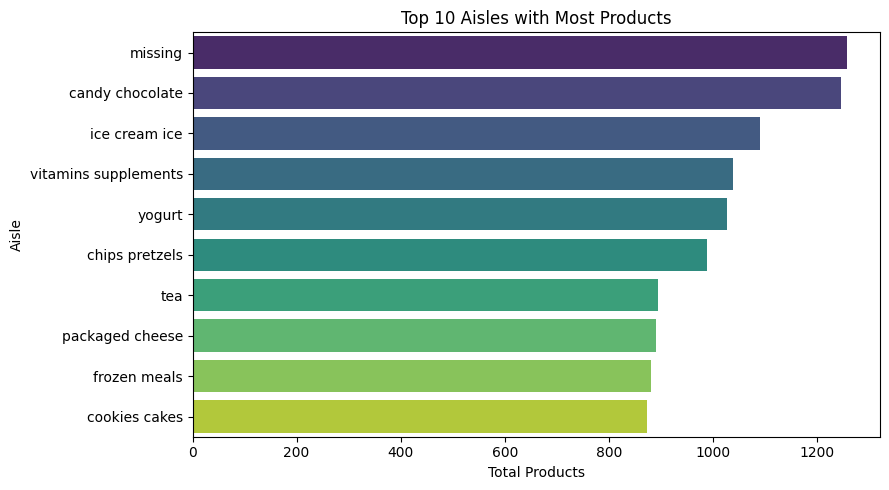

In [18]:
# Top 10 aisles with highest number of products
top_aisles = products_df.groupBy("aisle_id").agg(count("product_id").alias("total_products")) \
    .join(aisles_df, "aisle_id").orderBy(desc("total_products")).limit(10)
top_aisles.show()

# Convert Spark DataFrame to Pandas
top_aisles_pd = top_aisles.toPandas()

# plot
plt.figure(figsize=(9,5))
sns.barplot(data=top_aisles_pd, x="total_products", y="aisle", palette="viridis")
plt.title("Top 10 Aisles with Most Products")
plt.xlabel("Total Products")
plt.ylabel("Aisle")
plt.tight_layout()
plt.show()

+-------------+------------+---------------+
|department_id|num_products|     department|
+-------------+------------+---------------+
|           11|        6563|  personal care|
|           19|        6264|         snacks|
|           13|        5371|         pantry|
|            7|        4365|      beverages|
|            1|        4007|         frozen|
|           16|        3449|     dairy eggs|
|           17|        3085|      household|
|           15|        2092|   canned goods|
|            9|        1858|dry goods pasta|
|            4|        1684|        produce|
|            3|        1516|         bakery|
|           20|        1322|           deli|
|           21|        1258|        missing|
|            6|        1139|  international|
|           14|        1115|      breakfast|
|           18|        1081|         babies|
|            5|        1054|        alcohol|
|            8|         972|           pets|
|           12|         907|   meat seafood|
|         

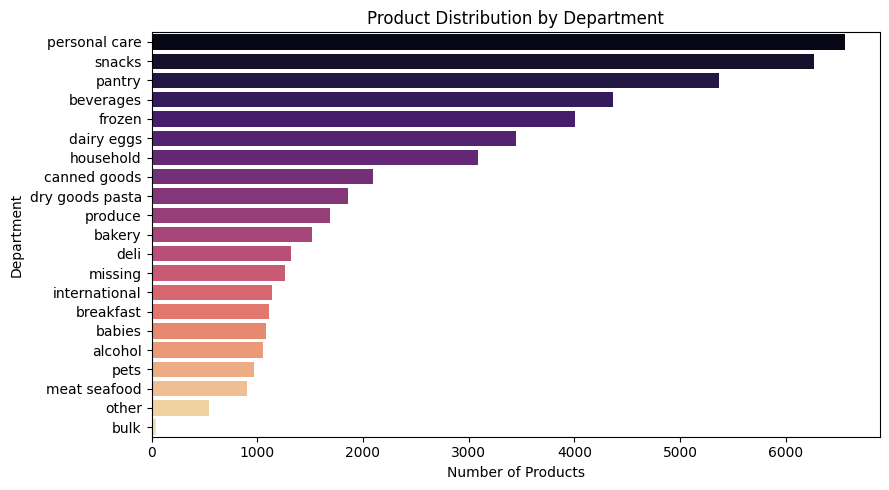

In [19]:
# Distribution of products across departments
product_dist_by_dept = products_df.groupBy("department_id") \
    .agg(count("product_id").alias("num_products")) \
    .join(departments_df, "department_id") \
    .orderBy(desc("num_products"))
product_dist_by_dept.show()

# Convert Spark DataFrame to Pandas
product_dist_pd = product_dist_by_dept.toPandas()

# Plot
plt.figure(figsize=(9,5))
sns.barplot(data=product_dist_pd, x="num_products", y="department", palette="magma")
plt.title("Product Distribution by Department")
plt.xlabel("Number of Products")
plt.ylabel("Department")
plt.tight_layout()
plt.show()

+----------+------------------+--------------------+--------+-------------+
|product_id|      reorder_rate|        product_name|aisle_id|department_id|
+----------+------------------+--------------------+--------+-------------+
|      6433|0.9411764705882353| Raw Veggie Wrappers|      13|           20|
|      2075|0.9310344827586207|Serenity Ultimate...|     126|           11|
|     43553|0.9230769230769231| Orange Energy Shots|      64|            7|
|     27740|0.9207920792079208|  Chocolate Love Bar|      45|           19|
|     14609|0.9142857142857143|Soy Powder Infant...|      92|           18|
|     13875|0.9111111111111111|Simply Sleep Nigh...|       6|            2|
|     39992|0.9090909090909091|Energy Shot, Grap...|      64|            7|
|      5868|               0.9|Russian River Val...|      28|            5|
|     31418|               0.9|      Sparking Water|     115|            7|
|     35604|               0.9|     Maca Buttercups|      45|           19|
+----------+

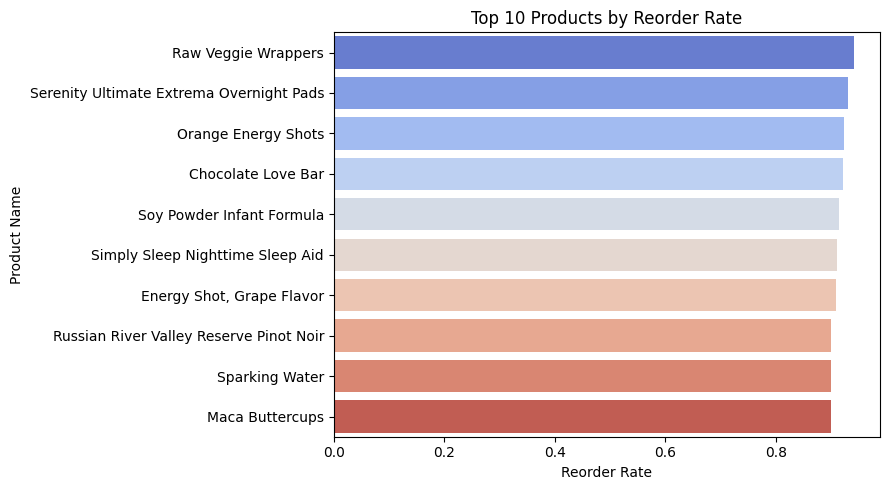

In [20]:
# Top 10 products by reorder rate
reorder_rates = order_products_prior_df.groupBy("product_id") \
    .agg(avg("reordered").alias("reorder_rate")) \
    .join(products_df, "product_id") \
    .orderBy(desc("reorder_rate")).limit(10)
reorder_rates.show()

# Convert Spark DataFrame to Pandas
reorder_rates_pd = reorder_rates.select("product_name", "reorder_rate").toPandas()

# Plot
plt.figure(figsize=(9,5))
sns.barplot(data=reorder_rates_pd, x="reorder_rate", y="product_name", palette="coolwarm")
plt.title("Top 10 Products by Reorder Rate")
plt.xlabel("Reorder Rate")
plt.ylabel("Product Name")
plt.tight_layout()
plt.show()

+--------------------+-----------+
|        product_name|order_count|
+--------------------+-----------+
|              Banana|     491291|
|Bag of Organic Ba...|     394930|
|Organic Strawberries|     275577|
|Organic Baby Spinach|     251705|
|Organic Hass Avocado|     220877|
|     Organic Avocado|     184224|
|         Large Lemon|     160792|
|        Strawberries|     149445|
|               Limes|     146660|
|  Organic Whole Milk|     142813|
+--------------------+-----------+



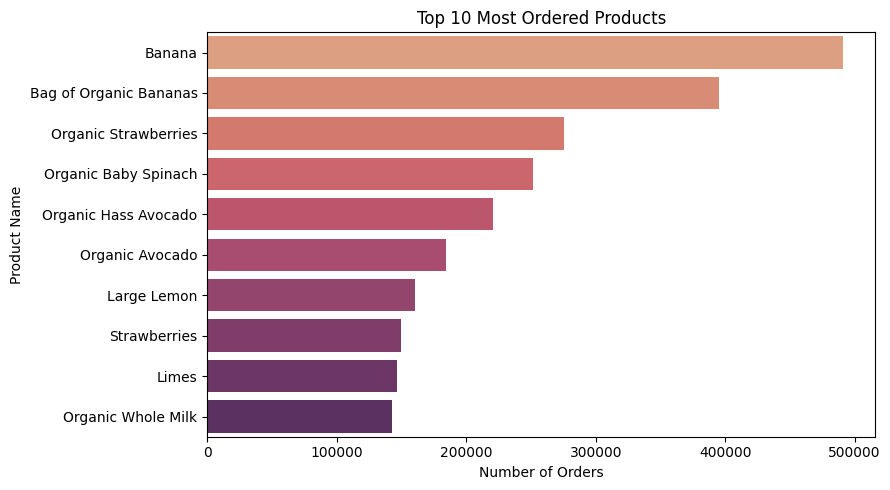

In [21]:
# Top 10 most ordered products
most_ordered_products = merged_df.groupBy("product_name") \
    .agg(count("*").alias("order_count")) \
    .orderBy(desc("order_count")).limit(10)
most_ordered_products.show()

# Convert Spark DataFrame to Pandas
most_ordered_pd = most_ordered_products.toPandas()

# Plot
plt.figure(figsize=(9,5))
sns.barplot(data=most_ordered_pd, x="order_count", y="product_name", palette="flare")
plt.title("Top 10 Most Ordered Products")
plt.xlabel("Number of Orders")
plt.ylabel("Product Name")
plt.tight_layout()
plt.show()

In [22]:
# Most reordered products per department
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

reordered_by_department = merged_df.groupBy("department_id", "product_name") \
    .agg(sum("reordered").alias("total_reorders"))

window = Window.partitionBy("department_id").orderBy(desc("total_reorders"))

top_reordered_by_dept = reordered_by_department.withColumn("rank", row_number().over(window)) \
    .filter(col("rank") == 1) \
    .join(departments_df, "department_id")
top_reordered_by_dept.show()

+-------------+--------------------+--------------+----+---------------+
|department_id|        product_name|total_reorders|rank|     department|
+-------------+--------------------+--------------+----+---------------+
|            1|         Blueberries|         33999|   1|         frozen|
|            2|Roasted Almond Bu...|          2825|   1|          other|
|            3|100% Whole Wheat ...|         46586|   1|         bakery|
|            4|              Banana|        415166|   1|        produce|
|            5|     Sauvignon Blanc|          5847|   1|        alcohol|
|            6|Organic Sea Salt ...|          6816|   1|  international|
|            7|Sparkling Water G...|         61175|   1|      beverages|
|            8|Grain Free Chicke...|          1345|   1|           pets|
|            9|      Marinara Sauce|         13025|   1|dry goods pasta|
|           10|         Dried Mango|          7903|   1|           bulk|
|           11|  Premium Epsom Salt|          2425|

In [23]:
# Products reordered more than once
reordered_more_than_once = merged_df.groupBy("product_id").agg(sum("reordered").alias("total_reorders")) \
    .filter(col("total_reorders") > 1)
reordered_more_than_once.show()

+----------+--------------+
|product_id|total_reorders|
+----------+--------------+
|      2040|            76|
|     18196|           136|
|     31762|            71|
|     38510|           540|
|     33862|           602|
|      5385|          3021|
|     29824|           443|
|     39527|          3373|
|      9458|           895|
|     15322|           280|
|     40634|           549|
|      2509|           138|
|     15663|            60|
|     47492|          3658|
|      8484|            90|
|     27469|             2|
|     11945|          2317|
|     15057|           582|
|     28242|           309|
|     38996|          4178|
+----------+--------------+
only showing top 20 rows



In [24]:
# Avg reorder rate per aisle
avg_reorder_aisle = merged_df.groupBy("aisle").agg(avg("reordered").alias("avg_reorder_rate")) \
    .orderBy(desc("avg_reorder_rate"))
avg_reorder_aisle.show()

+--------------------+------------------+
|               aisle|  avg_reorder_rate|
+--------------------+------------------+
|                milk|0.7818123355047696|
|water seltzer spa...|0.7299299664066503|
|        fresh fruits|0.7188227474061089|
|                eggs|0.7063594126383184|
|     soy lactosefree| 0.692360942854176|
|    packaged produce|0.6919768695075443|
|              yogurt|  0.68650084273967|
|               cream|0.6851839519551517|
|               bread| 0.670551827619813|
|        refrigerated|0.6630062309195822|
|    breakfast bakery|0.6513020823341173|
|energy sports drinks|0.6494734996354643|
|         soft drinks|0.6393011535086781|
|packaged vegetabl...| 0.639275498615364|
|         white wines|0.6319282057764014|
|    frozen breakfast|0.6271794533427907|
|       cat food care| 0.622251379965614|
| trail mix snack mix|0.6208674061479502|
|      prepared meals|0.6203169679639413|
|bulk dried fruits...|0.6197977118222517|
+--------------------+------------

+--------------------+---------------+--------------+
|               aisle|     department|products_count|
+--------------------+---------------+--------------+
|         asian foods|  international|           605|
|   baby food formula|         babies|           718|
|               cream|     dairy eggs|           161|
|      more household|      household|           308|
|frozen breads doughs|         frozen|            81|
|                eggs|     dairy eggs|           125|
|        frozen meals|         frozen|           880|
|canned jarred veg...|   canned goods|           487|
|       packaged meat|   meat seafood|           100|
|  ice cream toppings|         snacks|            85|
|        fresh fruits|        produce|           382|
|preserved dips sp...|         pantry|           264|
|              beauty|  personal care|           178|
|grains rice dried...|dry goods pasta|           336|
|    baby accessories|         babies|            44|
|         facial care|  pers

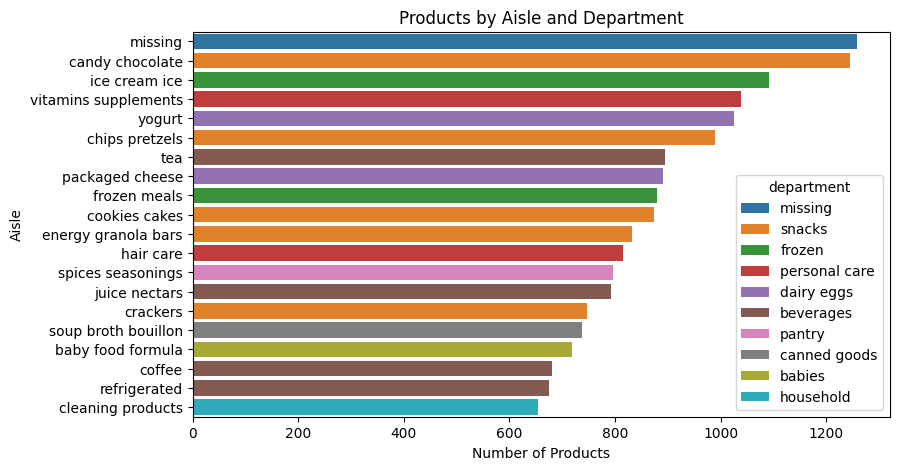

In [25]:
# Products per aisle and department
products_aisle_department = products_df.join(aisles_df, "aisle_id").join(departments_df, "department_id") \
    .groupBy("aisle", "department").agg(count("product_id").alias("products_count"))
products_aisle_department.show()

# Convert Spark DataFrame to Pandas
products_aisle_department_pd = products_aisle_department.orderBy(desc("products_count")).limit(20).toPandas()

# Plot
plt.figure(figsize=(9,5))
sns.barplot(data=products_aisle_department_pd, x="products_count", y="aisle", hue="department")
plt.title("Products by Aisle and Department")
plt.xlabel("Number of Products")
plt.ylabel("Aisle")
plt.show()

# Summary :

This analysis focused on evaluating the performance and structure of the product catalog by looking into which aisles and departments have the most products, the most reordered items, and the most ordered products overall.

We identified top-performing products that consistently attract repeat purchases and high volume, indicating strong customer preference and loyalty. The average reorder rate across aisles gave us insight into how different categories perform in terms of customer stickiness.

Additionally, the spread of products across aisles and departments revealed which categories are well-developed and which may need expansion or restructuring. This analysis is essential for inventory management, assortment planning, and promotional targeting — helping the business focus resources on what truly sells and retains customers.

✅ Business Impact: Enables better stocking, bundling, cross-sell strategies, and product visibility in key categories.



# Customer Behavior Analysis

In [27]:
# Unique users
unique_users = orders_df.select("user_id").distinct().count()
print("Unique_users :", unique_users)

Unique_users : 206209


In [28]:
# Avg days between orders per user
avg_days_per_user = orders_df.groupBy("user_id").agg(avg("days_since_prior_order").alias("avg_days")).orderBy("user_id",ascending=True)
avg_days_per_user.show()

+-------+------------------+
|user_id|          avg_days|
+-------+------------------+
|      1|17.181818181818183|
|      2|15.133333333333333|
|      3|              11.0|
|      4|              14.0|
|      5|               9.0|
|      6|              9.75|
|      7| 9.904761904761905|
|      8|             17.25|
|      9|             16.25|
|     10|              18.0|
|     11|             16.25|
|     12|              21.5|
|     13|               7.0|
|     14|19.642857142857142|
|     15|10.130434782608695|
|     16|16.428571428571427|
|     17| 7.780487804878049|
|     18| 4.857142857142857|
|     19|               8.3|
|     20|               8.8|
+-------+------------------+
only showing top 20 rows



+-------------+----------+---------------+
|department_id|user_count|     department|
+-------------+----------+---------------+
|           19|    177070|         snacks|
|            7|    175482|      beverages|
|            6|     79357|  international|
|            9|    127985|dry goods pasta|
|           17|    114823|      household|
|            5|     16104|        alcohol|
|            1|    166124|         frozen|
|           10|     12973|           bulk|
|            3|    143772|         bakery|
|           12|    116851|   meat seafood|
|            8|     15484|           pets|
|           11|     97155|  personal care|
|            2|     18750|          other|
|            4|    194331|        produce|
|           13|    175882|         pantry|
|           18|     34782|         babies|
|           14|    117338|      breakfast|
|           21|     30950|        missing|
|           15|    136937|   canned goods|
|           20|    137143|           deli|
+----------

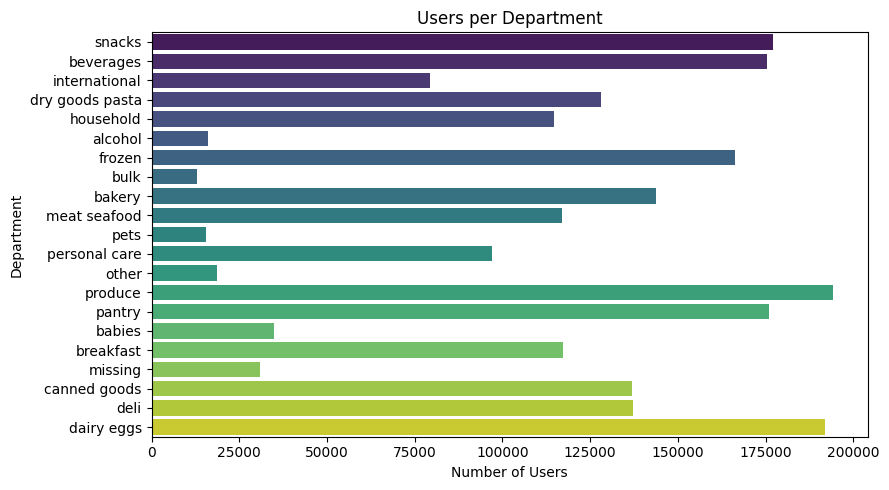

In [29]:
# Users per department
users_per_department = merged_df.select("user_id", "department_id").distinct() \
    .groupBy("department_id").agg(count("user_id").alias("user_count")) \
    .join(departments_df, "department_id")
users_per_department.show()

# Convert Spark DataFrame to Pandas
users_per_dept_pd = users_per_department.toPandas()

# Plot
plt.figure(figsize=(9,5))
sns.barplot(data=users_per_dept_pd, x="user_count", y="department", palette="viridis")
plt.title("Users per Department")
plt.xlabel("Number of Users")
plt.ylabel("Department")
plt.tight_layout()
plt.show()

In [39]:
# One-time vs Repeat Buyers
from pyspark.sql.functions import countDistinct

orders_per_user = orders_df.groupBy("user_id").agg(countDistinct("order_id").alias("order_count"))

repeat_vs_new = orders_per_user.withColumn("user_type", 
    when(col("order_count") > 1, "Repeat").otherwise("One-time")) \
    .groupBy("user_type").count()
repeat_vs_new.show()


+---------+------+
|user_type| count|
+---------+------+
|   Repeat|206209|
+---------+------+



In [30]:
# Top 10 users by order count
top_users_df = (
    orders_df.groupBy("user_id")
    .agg(count("order_id").alias("num_orders"))
    .orderBy(desc("num_orders"))
    .limit(10)
)
top_users_df.show()

+-------+----------+
|user_id|num_orders|
+-------+----------+
|  59819|       100|
|   7278|       100|
|  43529|       100|
|   8220|       100|
|  11334|       100|
|  55806|       100|
|   7279|       100|
|  20451|       100|
|  43352|       100|
|  58843|       100|
+-------+----------+



# Summary :

In this section, we explored how users interact with the platform — how often they order, how loyal they are, and which departments they engage with most.

We identified one-time vs repeat buyers, calculated average days between orders, and highlighted the most active users. This helped paint a picture of user retention and engagement. Also, analyzing user behavior at a department level helped us understand category-wise user preference and behavior.

Such analysis is critical to understanding the health of the customer base, identifying churn risk, and planning targeted retention campaigns. It also supports segmentation strategies for rewards programs and high-LTV (lifetime value) user retention.

✅ Business Impact: Helps build data-driven customer retention strategies and personalized marketing to reduce churn and increase loyalty.

# Order Pattern & Time-Based Analysis

+-----------------+------------+
|order_hour_of_day|total_orders|
+-----------------+------------+
|                0|       22758|
|                1|       12398|
|                2|        7539|
|                3|        5474|
|                4|        5527|
|                5|        9569|
|                6|       30529|
|                7|       91868|
|                8|      178201|
|                9|      257812|
|               10|      288418|
|               11|      284728|
|               12|      272841|
|               13|      277999|
|               14|      283042|
|               15|      283639|
|               16|      272553|
|               17|      228795|
|               18|      182912|
|               19|      140569|
|               20|      104292|
|               21|       78109|
|               22|       61468|
|               23|       40043|
+-----------------+------------+



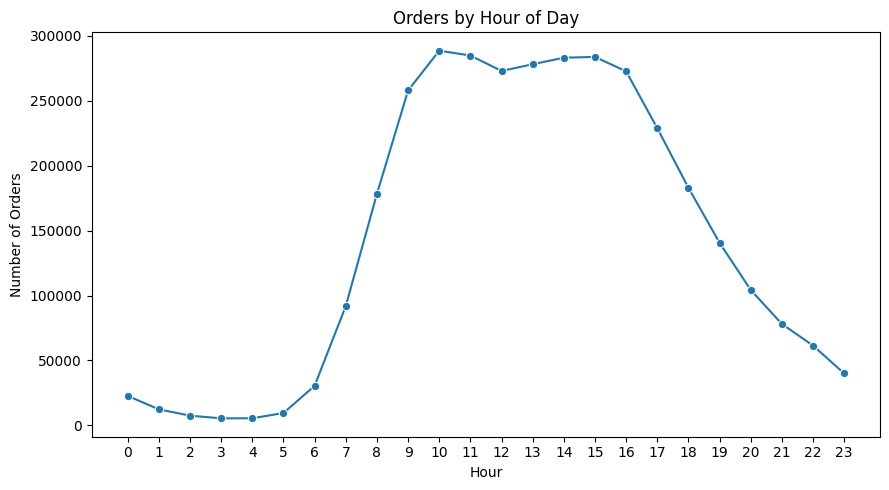

In [32]:
# Peak order hours
orders_by_hour = orders_df.groupBy("order_hour_of_day").agg(count("order_id").alias("total_orders")) \
    .orderBy("order_hour_of_day")
orders_by_hour.show(24)

# Convert Spark DataFrame to Pandas
orders_by_hour_pd = orders_by_hour.toPandas()

# Plot
plt.figure(figsize=(9,5))
sns.lineplot(data=orders_by_hour_pd, x="order_hour_of_day", y="total_orders", marker="o")
plt.title("Orders by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Orders")
plt.xticks(range(0,24))
plt.tight_layout()
plt.show()

+---------+------------+
|order_dow|total_orders|
+---------+------------+
|        0|      600905|
|        1|      587478|
|        2|      467260|
|        3|      436972|
|        4|      426339|
|        5|      453368|
|        6|      448761|
+---------+------------+



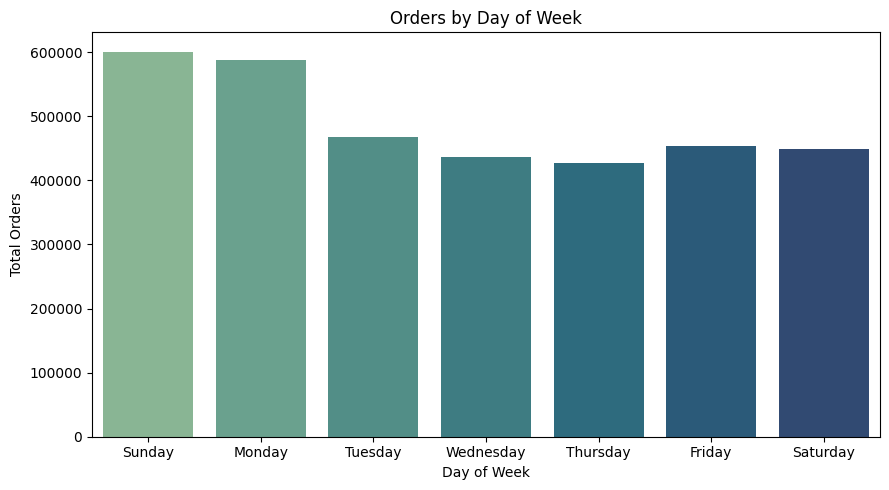

In [33]:
# Orders by day of week
orders_by_dow = orders_df.groupBy("order_dow").agg(count("order_id").alias("total_orders")) \
    .orderBy("order_dow")
orders_by_dow.show()

# Mapping order_dow numbers to weekday names
dow_map = {0: "Sunday", 1: "Monday", 2: "Tuesday", 3: "Wednesday",
    4: "Thursday", 5: "Friday", 6: "Saturday"}

# Convert Spark DataFrame to Pandas
orders_by_dow_pd = orders_by_dow.toPandas()

# Apply mapping
orders_by_dow_pd["Day"] = orders_by_dow_pd["order_dow"].map(dow_map)

# Optional: sort by actual weekday order
weekday_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
orders_by_dow_pd["Day"] = pd.Categorical(orders_by_dow_pd["Day"], categories=weekday_order, ordered=True)
orders_by_dow_pd = orders_by_dow_pd.sort_values("Day")

# Plot
plt.figure(figsize=(9,5))
sns.barplot(data=orders_by_dow_pd, x="Day", y="total_orders", palette="crest")
plt.title("Orders by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Total Orders")
plt.tight_layout()
plt.show()

+---------+--------------+------------+--------------+
|order_dow|total_products|total_orders|avg_order_size|
+---------+--------------+------------+--------------+
|        0|       6533692|      585237|         11.16|
|        6|       4707583|      437749|         10.75|
|        5|       4386443|      443388|          9.89|
|        1|       5871834|      576377|         10.19|
|        3|       3998498|      428087|          9.34|
|        2|       4378360|      458074|          9.56|
|        4|       3942696|      417171|          9.45|
+---------+--------------+------------+--------------+



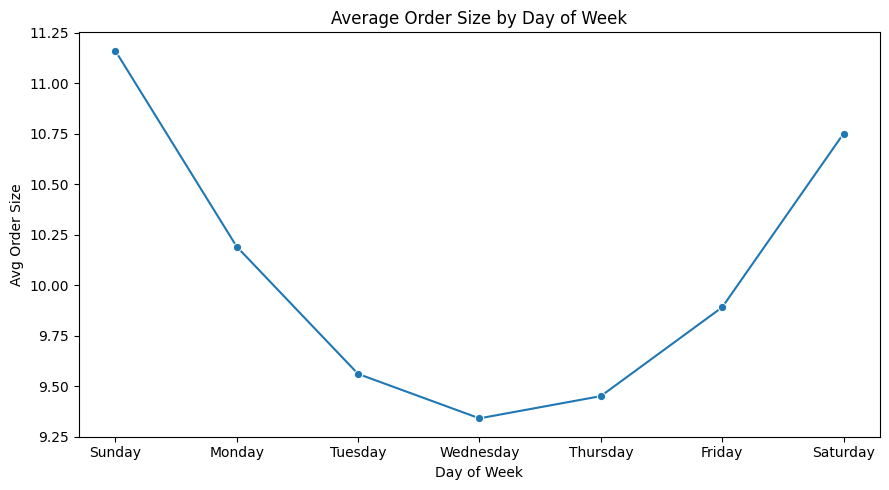

In [34]:
# Avg order size by day of week
order_size_dow_df = merged_df.groupBy("order_dow").agg(count("product_id").alias("total_products"),
                                                     countDistinct("order_id").alias("total_orders")) \
    .withColumn("avg_order_size", round(col("total_products") / col("total_orders"), 2))
order_size_dow_df.show()

# Convert Spark DataFrame to Pandas
order_size_dow_pd = order_size_dow_df.select("order_dow", "avg_order_size").orderBy("order_dow").toPandas()

# Apply mapping
order_size_dow_pd["Day"] = order_size_dow_pd["order_dow"].map(dow_map)


# Plot
plt.figure(figsize=(9,5))
sns.lineplot(data=order_size_dow_pd, x="Day", y="avg_order_size", marker="o")
plt.title("Average Order Size by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Avg Order Size")
plt.tight_layout()
plt.show()

# Summary

This part of the analysis revealed when users are most likely to place their orders — both in terms of hourly patterns and days of the week.

We found clear peaks during mid-morning to early afternoon (10 AM – 2 PM), and strong order volumes on weekends, particularly Saturdays and Sundays. We also looked at order size by day, showing that users tend to place larger orders on weekends, indicating stock-up behavior.

Understanding these time-based behaviors is crucial for marketing timing, ad delivery, customer notifications, and resource planning. Operations and marketing teams can align their schedules, workforce, and campaigns to match high-traffic periods for maximum effectiveness.

✅ Business Impact: Allows better alignment of operations, staffing, and ad campaigns with actual user behavior patterns.

# Basket / Cart Behavior Analysis

+----------+---------+
|order_size|frequency|
+----------+---------+
|         5|   237225|
|         6|   236383|
|         4|   230299|
|         7|   228547|
|         3|   215060|
|         8|   211357|
|         2|   194361|
|         9|   191564|
|        10|   172103|
|         1|   163593|
|        11|   153495|
|        12|   136963|
|        13|   121714|
|        14|   108077|
|        15|    95475|
|        16|    84714|
|        17|    74468|
|        18|    65348|
|        19|    57290|
|        20|    50198|
+----------+---------+
only showing top 20 rows



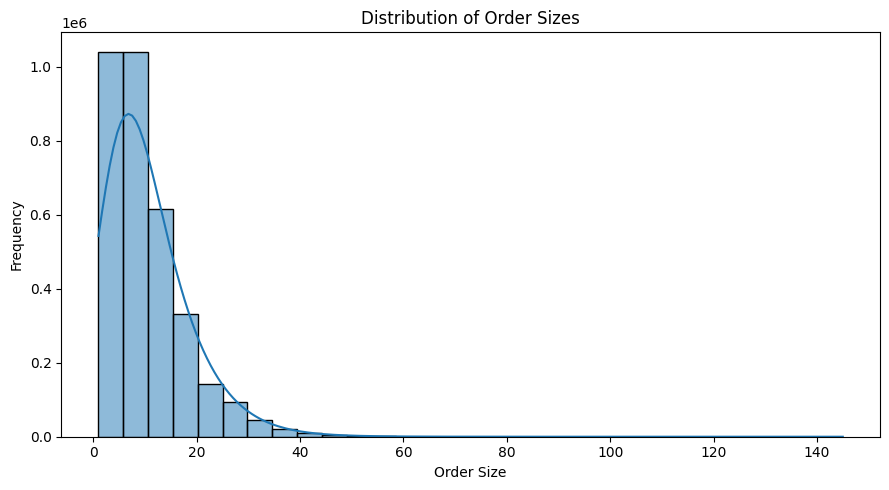

In [36]:
# Distribution of order sizes
order_size_dist = order_products_df.groupBy("order_id").agg(count("product_id").alias("order_size")) \
    .groupBy("order_size").agg(count("order_id").alias("frequency")).orderBy("frequency",ascending=False)
order_size_dist.show()

# Convert Spark DataFrame to Pandas
order_size_dist_pd = order_size_dist.orderBy("order_size").toPandas()

# Plot
plt.figure(figsize=(9,5))
sns.histplot(data=order_size_dist_pd,x="order_size",weights="frequency",bins=30,kde=True)
plt.title("Distribution of Order Sizes")
plt.xlabel("Order Size")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [37]:
# Avg products in cart per order
avg_cart_size = order_products_prior_df.groupBy("order_id").agg(count("product_id").alias("cart_size")) \
    .agg(avg("cart_size")).collect()[0][0]
print("avg_cart_size :",avg_cart_size)

avg_cart_size : 10.088883421247614


In [38]:
# Average number of products per order
avg_products_per_order = order_products_df.groupBy("order_id").agg(count("*").alias("product_count")) \
    .agg(avg("product_count").alias("avg_products"))
avg_products_per_order.show()

+-----------------+
|     avg_products|
+-----------------+
|10.10707325550502|
+-----------------+



In [78]:
# products are always added last in the cart

# Step 1: Calculate average cart position for each product
product_last_added = order_products_df.groupBy("product_id") \
    .agg(avg("add_to_cart_order").alias("avg_position")) \
    .orderBy("avg_position", ascending=False)

# Step 2: Join with products_df to get product names
product_last_named = product_last_added.join(products_df, on="product_id", how="left") \
    .select("product_id", "product_name", "avg_position") \
    .orderBy("avg_position", ascending=False)

# Step 3: Show top 10
product_last_named.show(10, truncate=False)


+----------+---------------------------------------------+------------------+
|product_id|product_name                                 |avg_position      |
+----------+---------------------------------------------+------------------+
|20223     |Citronge Extra Fine Orange Liqueur           |53.0              |
|43778     |Strawberry Energy Gel                        |50.0              |
|22747     |Vanilla Bean Sheep Milk Ice Cream            |46.0              |
|33406     |Eczema Control                               |41.0              |
|13397     |Molasses, Bead                               |34.0              |
|23653     |Aged Parmesan Cheese Sticks                  |33.0              |
|37014     |Sloppy Joe Sandwich Makers                   |33.0              |
|38977     |Original Jerky                               |32.0              |
|45319     |Original Submarine Dressing                  |31.833333333333332|
|24280     |Natural Blueberries Covered In Dark Chocolate|31.125

# Summary:

This section explored the depth of user engagement during their ordering session — such as how many items they typically purchase, how they build their carts, and what products are added early or late.

We analyzed average products per order, cart size distributions, and the average cart position for products. This revealed upsell potential, as well as key differences between small and large order customers. Products frequently added early may be essential goods, while those added last may be impulse or recommendation-driven items.

These insights help refine product recommendation engines, personalized product placements, and cross-selling strategies. It also aids in UI/UX decisions for better cart conversion flow.

✅ Business Impact: Informs how to personalize product suggestions, improve cart UX, and maximize order value through intelligent merchandising.

# Final Business Value Summary

By combining product insights, customer behavior, timing trends, and basket patterns, this comprehensive analysis enables 360° business understanding. It supports:

- Better inventory and merchandising decisions

- More effective customer segmentation and targeting

- Smarter operational and marketing alignment

- Stronger user engagement and satisfaction

These insights form the foundation for data-driven growth strategies in e-commerce, retail, or grocery businesses.